# Project 3: Additional exercise 
## Bias-Variance tradeoff analysis

In this exercise, we use  100 data points generated with the Franke Function and perform the regression task with 3 algorithms.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from FrankeFunction import FrankeFunction
from sklearn.neural_network import MLPRegressor
from Functions import LinReg, DesignMatrix
from sklearn.tree import DecisionTreeRegressor

In [43]:
np.random.seed(2003)

n = 100
x1 = np.random.uniform(0,1,n)
x2 = np.random.uniform(0,1,n)

#Define noise
var = 0.1
noise = np.random.normal(0,var,n)

y = FrankeFunction(x1,x2) + noise 

Data preparation, train-test split , no scaling required here:

In [44]:
x1 = np.array(x1).reshape(n,1)
x2 = np.array(x2).reshape(n,1)
x = np.hstack((x1,x2)).reshape(n,2)

#Split train (80%) and test(20%) data before looping on polynomial degree
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Method 1: Bootstrapped Ordinary Least square 

Define maximum problem complexity and bootstrapping parameters:

In [45]:
#Define maximal model complexity
maxdegree= 7

#Number of bootstraps
n_bootstraps = 75

Initialization before looping:

In [46]:
TestError = np.zeros(maxdegree)
TrainError = np.zeros(maxdegree)
TestR2 = np.zeros(maxdegree)
TrainR2 = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
predictor =[]

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

#Initialize bootstrap matrix
y_pred = np.empty((y_test.shape[0],n_bootstraps))

Looping through polynomial degree:

In [47]:
for degree in range(maxdegree):
    
    for i in range(n_bootstraps):
        x_, y_ = resample(x_train,y_train)
  
        X_train = DesignMatrix(x_[:,0],x_[:,1],degree+1)
        X_test = DesignMatrix(x_test[:,0],x_test[:,1],degree+1)
        y_fit, y_pred[:,i], Beta = LinReg(X_train, X_test, y_)
                
    y_test = np.reshape(y_test, (len(y_test),1))
    predictor=np.append(predictor,Beta)
    polydegree[degree] = degree+1
    
    
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    

Plot bias, variance and mean squared error against polynomial degree:

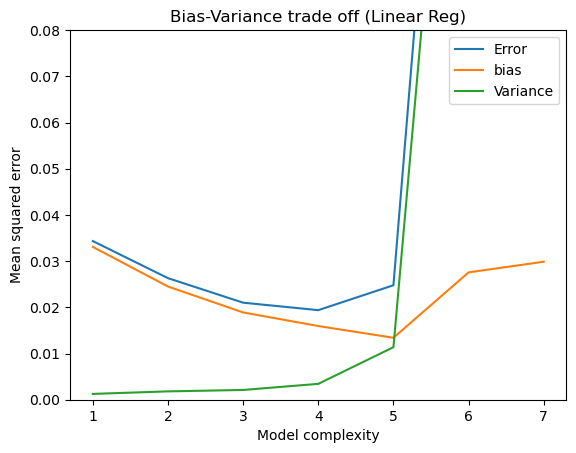

In [48]:
plt.ylim((0,0.08))       
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xticks(np.arange(1, len(polydegree)+1, step=1))  # Set label locations.
plt.xlabel('Model complexity')
plt.ylabel('Mean squared error')
plt.title('Bias-Variance trade off (Linear Reg)')
plt.legend()
plt.show()

## Method 2: Bootstrapped Feed-Forward Neural Network
Define maximal network depth, number of nodes per hidden layer and bootstrapping parameters:

In [49]:
nodes = 4
n_hidden_neurons = []
maxdepth = 6

#Number of bootstraps
n_bootstraps = 75


Data preparation and initialization:

In [50]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


M = 20   #size of each minibatch
m = int(y.shape[0]/M) #number of minibatches
epochs = 10000 #number of epochs 

#Define hyperparameters 
lmbd = 0.001
eta = 0.01

#Initialization

#bootstrap matrix
y_pred = np.empty((y_test.shape[0],n_bootstraps))

#
n_layer = np.zeros(maxdepth+1)
error = np.zeros(maxdepth+1)
bias = np.zeros(maxdepth+1)
variance = np.zeros(maxdepth+1)

Looping though network depth e.g number of hidden layer (note that the number of nodes for each layer is the same):

In [51]:
for depth in range(maxdepth+1):
    
    for i in range(n_bootstraps):
        x_, y_ = resample(x_train,y_train)
  
        #####scikit NN implementation#####
        dnn = MLPRegressor(hidden_layer_sizes=n_hidden_neurons, solver = 'lbfgs', activation='logistic',
                            alpha=lmbd, batch_size = M, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(x_, y_)
        y_pred[:,i] = dnn.predict(x_test)
                
    y_test = np.reshape(y_test, (len(y_test),1)) 
    n_layer[depth] = depth
    
    error[depth] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[depth] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[depth] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    
    n_hidden_neurons = np.append(n_hidden_neurons, int(nodes))
    n_hidden_neurons = list(map(int,n_hidden_neurons))


Plot bias, variance and mean squared error against FFNN depth:

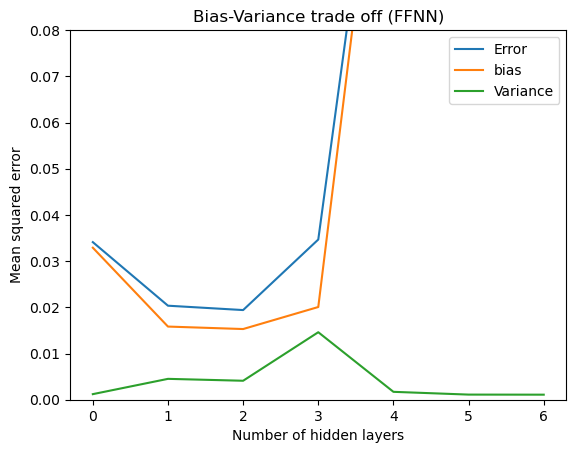

In [52]:
plt.ylim((0,0.08))   
plt.plot(n_layer, error, label='Error')
plt.plot(n_layer, bias, label='bias')
plt.plot(n_layer, variance, label='Variance')
plt.xticks(np.arange(0, len(n_layer), step=1))  # Set label locations.
plt.xlabel('Number of hidden layers')
plt.ylabel('Mean squared error')
plt.title('Bias-Variance trade off (FFNN)')
plt.legend()
plt.show()

## Method 3: Bootstrapped Regression Tree
Define maximum tree depth and bootstrapping parameters:

In [53]:
#Number of bootstraps
n_bootstraps = 75

#Tree depth
maxdepth = 7

Initialization:

In [54]:
n_layer = np.zeros(maxdepth+1)
error = np.zeros(maxdepth+1)
bias = np.zeros(maxdepth+1)
variance = np.zeros(maxdepth+1)

#Initialize bootstrap matrix
y_pred = np.empty((y_test.shape[0],n_bootstraps))

Looping through problem complexity:

In [55]:
for depth in range(1,maxdepth+1):
    
    for i in range(n_bootstraps):
        x_, y_ = resample(x_train,y_train)
  
        #####scikit Regression tree implementation#####
        rg_tree = DecisionTreeRegressor(max_depth = depth,random_state=0)
        rg_tree.fit(x_, y_)
        y_pred[:,i] = rg_tree.predict(x_test)
                
    y_test = np.reshape(y_test, (len(y_test),1)) 
    n_layer[depth] = depth
    
    error[depth] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[depth] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[depth] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    
    n_hidden_neurons = np.append(n_hidden_neurons, int(nodes))
    n_hidden_neurons = list(map(int,n_hidden_neurons))

Plot bias, variance and mean squared error against tree depth:

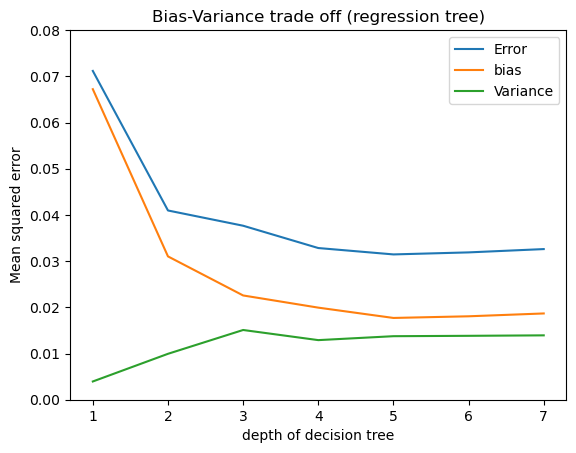

In [56]:
plt.ylim((0,0.08))   
plt.plot(n_layer[1:], error[1:], label='Error')
plt.plot(n_layer[1:], bias[1:], label='bias')
plt.plot(n_layer[1:], variance[1:], label='Variance')
plt.xticks(np.arange(1, len(n_layer), step=1))  # Set label locations.
plt.xlabel('depth of decision tree')
plt.ylabel('Mean squared error')
plt.title('Bias-Variance trade off (regression tree)')
plt.legend()

plt.show()


## Discussion and conclusion:

For linear regression, we clearly observe that the mean squared error is dominated by the variance  for polynomial degree above 4. The method is very sensitive to overfitting as the prediction error deteriorates quickly after the optimal complexity is reached. High variance is the dominant source of error.

In contrast, we see an opposite effect for FFNN as the bias dominates the prediction error in the overfitting domain (depth of the network superior to 2).

For OLS and FFNN, a similar test error of 0.02 for the optimal parametrization.

For regression tree, the prediction error stabilizes with increasing problem complexity. This means that the method is rather robust to overfitting in comparison to OLS and FFNN. However, we see that the bias and variance are maintained a higher level 0.02 (bias) and 0.017 (variance) meaning that decision tree underperforms OLS and FFNN for this regression task.